In [1]:
import pandas as pd
import numpy as np
import itertools
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from pmdarima import auto_arima
import modules.ts_util as util
                   

In [3]:
df = pd.read_csv('data/GlobalTemperatures.csv', parse_dates=True, index_col='dt').dropna(how='any')
df.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,,,,,,,
1850-01-01,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367
1850-02-01,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414
1850-03-01,4.954,0.955,10.347,2.401,-1.905,1.410,14.043,0.341
1850-04-01,7.217,0.665,12.934,1.004,1.018,1.329,14.667,0.267
1850-05-01,10.004,0.617,15.655,2.406,3.811,1.347,15.507,0.249


In [4]:
df_M = df[['LandAverageTemperature']].resample('MS').mean()

df_M.head()

,LandAverageTemperature
dt,
1850-01-01,0.749
1850-02-01,3.071
1850-03-01,4.954
1850-04-01,7.217
1850-05-01,10.004


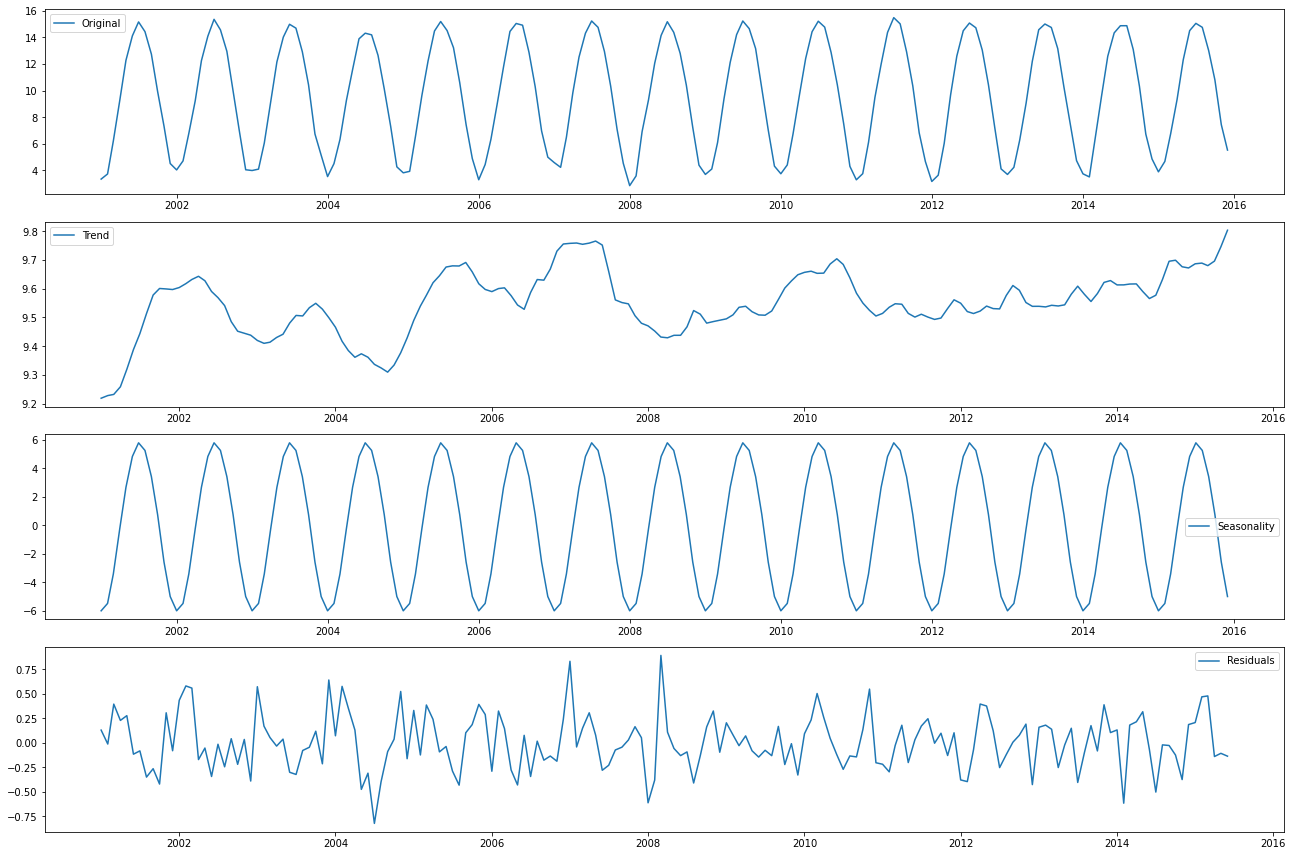

In [75]:
decomposition = seasonal_decompose(df_M['LandAverageTemperature'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(figsize=(18, 12))
plt.subplot(411)
plt.plot(df_M['LandAverageTemperature'][-180:], label='Original')
plt.legend(loc=0)
plt.subplot(412)
plt.plot(trend[-180:], label='Trend')
plt.legend(loc=0)
plt.subplot(413)
plt.plot(seasonal[-180:],label='Seasonality')
plt.legend(loc=0)
plt.subplot(414)
plt.plot(residual[-180:], label='Residuals')
plt.legend(loc=0)
plt.tight_layout()

plt.savefig('images/decomposition.png')

In [6]:
print(util.get_adf_test_outputs(df_M['LandAverageTemperature']))

ADF Test Statistic        -1.455300
p-value                    0.555500
# Lags Used               26.000000
# Observations Used     1965.000000
Critical Value (1%)       -3.433682
Critical Value (5%)       -2.863012
Critical Value (10%)      -2.567554
dtype: float64


In [7]:
df_diff = df_M.join(df_M['LandAverageTemperature'].diff().rename('Diff')).dropna()
df_diff.head()

,LandAverageTemperature,Diff
dt,,
1850-02-01,3.071,2.322
1850-03-01,4.954,1.883
1850-04-01,7.217,2.263
1850-05-01,10.004,2.787
1850-06-01,13.150,3.146


In [8]:
df_diff.isna().sum()

LandAverageTemperature    0
Diff                      0
dtype: int64

In [76]:
print(util.get_adf_test_outputs(df_diff['Diff']))

ADF Test Statistic       -12.581600
p-value                    0.000000
# Lags Used               26.000000
# Observations Used     1964.000000
Critical Value (1%)       -3.433684
Critical Value (5%)       -2.863013
Critical Value (10%)      -2.567554
dtype: float64


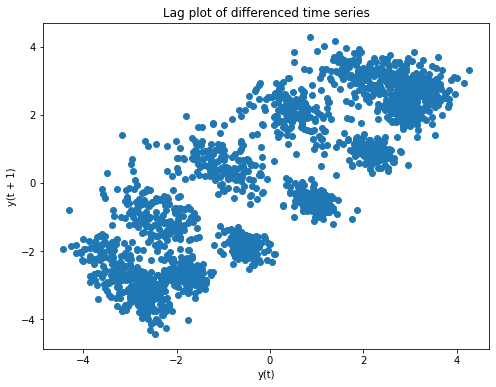

In [68]:
fig = plt.figure(figsize=(8,6))
pd.plotting.lag_plot(df_diff['Diff'])
plt.title('Lag plot of differenced time series')
plt.savefig('images/lag-plot.png')

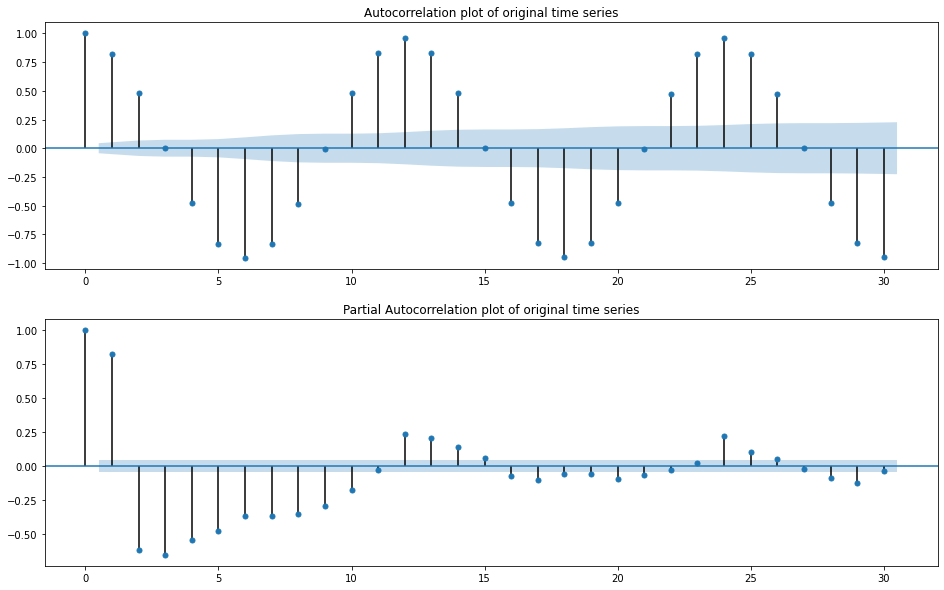

In [69]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_diff['Diff'], lags=30, ax=ax1, title='Autocorrelation plot of original time series')
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_diff['Diff'], lags=30, ax=ax2, title='Partial Autocorrelation plot of original time series')

plt.savefig('images/correlogram.png')

In [41]:
train=df_diff[:round(df_diff.shape[0]*90/100)]['Diff']
test=df_diff[round(df_diff.shape[0]*90/100):]['Diff']

print(train.shape, test.shape)

(1792,) (199,)


In [42]:
stepwise_fit_1 = auto_arima(train, seasonal=True, m=12, trace=False, stationary=True)
stepwise_fit_1

ARIMA(maxiter=50, method='lbfgs', order=(0, 0, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(2, 0, 2, 12),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [43]:
order=stepwise_fit_1.order
seasonal_order=stepwise_fit_1.seasonal_order

pred_results=SARIMAX(train, order=order, seasonal_order=seasonal_order, \
                      enforce_stationarity=False, enforce_invertibility=False).fit()
pred_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                    Diff   No. Observations:                 1792
Model:             SARIMAX(0, 0, 3)x(2, 0, [1, 2], 12)   Log Likelihood                -576.968
Date:                                 Wed, 20 May 2020   AIC                           1169.935
Time:                                         16:46:34   BIC                           1213.738
Sample:                                     02-01-1850   HQIC                          1186.121
                                          - 05-01-1999                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7786      0.029    -27.054      0.000      -0.835      -0.722
ma.L2         -0.2155      0.026     -8.318      0.000      -0.266      -0.165
ma.L3         -0.1075      0.026     -4.203      0.000      -0.158      -0.057
ar.S.L12       0.4212      0.138      3.053      0.002       0.151       0.692
ar.S.L24       0.5780      0.138      4.191      0.000       0.308       0.848
ma.S.L12      -0.4506      0.142     -3.171      0.002      -0.729      -0.172
ma.S.L24      -0.5651      0.143     -3.953      0.000      -0.845      -0.285
sigma2         0.0936      0.004     26.328      0.000       0.087       0.101
===================================================================================
Ljung-Box (Q):                       67.92   Jarque-Bera (JB):               229.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
start = len(train)
end = len(train) + len(test) - 1
print(start, end)

predictions = pred_results.predict(start=start, end=end, typ='levels', dynamic=True).rename('SARIMA Predictions')


1792 1990


In [45]:
mse, rmse = util.measure_pred_errors(test,predictions)
print(rmse)

0.3551


In [46]:
predictions = (predictions+df_diff['LandAverageTemperature'].shift())[start:end].rename('Predicted')
df_pred = df_diff[['LandAverageTemperature']][start:end].rename(columns={'LandAverageTemperature':'Actual'})
df_pred = df_pred.join(predictions)
df_pred

,Actual,Predicted
dt,,
1999-06-01,14.031,13.967492
1999-07-01,14.853,14.980804
1999-08-01,14.348,14.348712
1999-09-01,12.723,12.576438
1999-10-01,9.997,10.156878
...,...,...
2015-07-01,15.051,15.420506
2015-08-01,14.755,14.541916
2015-09-01,12.999,12.986102


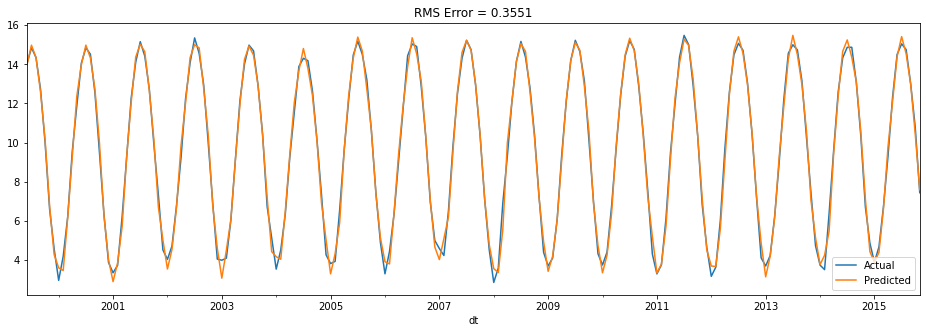

In [70]:
df_pred['Actual'].plot(legend=True, figsize=(16,5));
df_pred['Predicted'].plot( legend=True);
plt.legend(loc=0)
plt.title('RMS Error = {}'.format(rmse))

plt.savefig('images/prediction.png')

In [48]:
stepwise_fit_2 = auto_arima(df_M['LandAverageTemperature'], seasonal=True, m=12, trace=False, stationary=False)
stepwise_fit_2

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(2, 0, 1, 12),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [49]:
order=stepwise_fit_2.order
seasonal_order=stepwise_fit_2.seasonal_order

fc_results=SARIMAX(df_M['LandAverageTemperature'], order=order, seasonal_order=seasonal_order, \
                   enforce_stationarity=True, enforce_invertibility=False).fit()

fc_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:             LandAverageTemperature   No. Observations:                 1992
Model:             SARIMAX(0, 1, 1)x(2, 0, 1, 12)   Log Likelihood                -748.165
Date:                            Wed, 20 May 2020   AIC                           1506.330
Time:                                    17:24:55   BIC                           1534.312
Sample:                                01-01-1850   HQIC                          1516.607
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7763      0.013    -61.493      0.000      -0.801      -0.752
ar.S.L12       0.9408      0.001   1471.323      0.000       0.940       0.942
ar.S.L24       0.0591      0.001     92.275      0.000       0.058       0.060
ma.S.L12      -0.8984      0.011    -84.357      0.000      -0.919      -0.878
sigma2         0.1199      0.001     81.944      0.000       0.117       0.123
===================================================================================
Ljung-Box (Q):                      150.02   Jarque-Bera (JB):               206.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
forecast = fc_results.forecast(steps=96, typ='levels').rename('Forecast')
forecast.to_frame().head(12)

,Forecast
2016-01-01,4.017124
2016-02-01,4.505930
2016-03-01,6.753045
2016-04-01,9.811917
2016-05-01,12.621558
2016-06-01,14.738618
2016-07-01,15.510246
2016-08-01,15.109532
2016-09-01,13.353235
2016-10-01,10.705194


Text(0, 0.5, 'Average Land Temp (C) ')

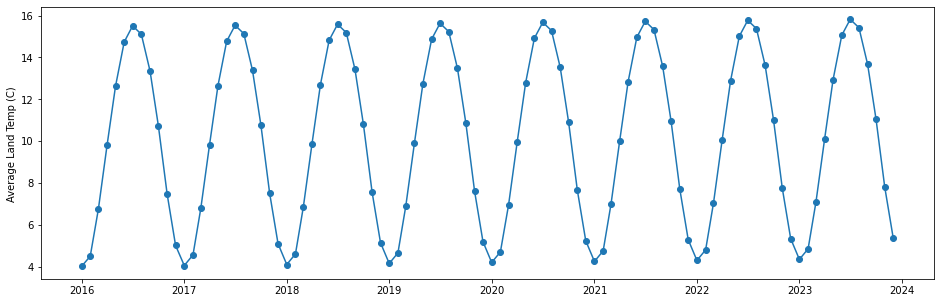

In [58]:
plt.subplots(figsize=(16, 5))
plt.plot_date(forecast.index,forecast, linestyle ='solid');
plt.ylabel('Average Land Temp (C) ')

plt.savefig('images/forecast.png')

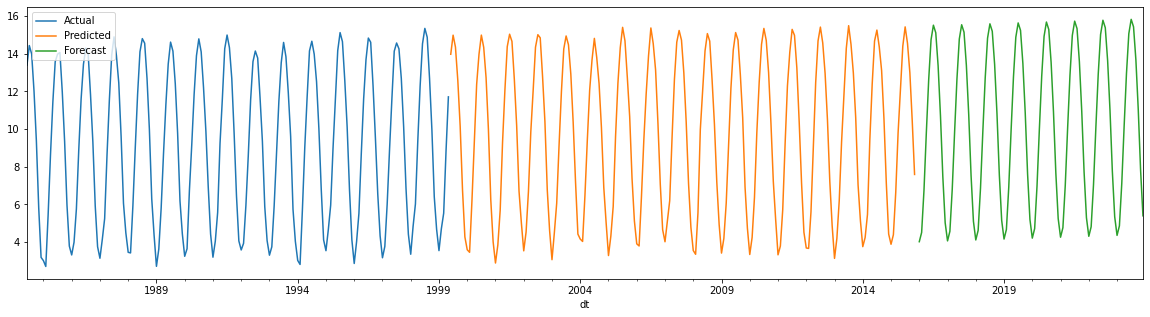

In [74]:
df_diff['LandAverageTemperature'][start-180:start].rename('Actual').plot( legend=True, figsize=(20, 5));
df_pred['Predicted'].plot( legend=True);
forecast.plot( legend=True);
plt.legend(loc=2)

plt.savefig('images/actual-prediction-forecast.png')